In [142]:
from __future__ import absolute_import, print_function, unicode_literals
import sys
import os
import repackage
repackage.up(stepup=2)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import analysis2 as a2
from flutype.models import Spot
import django
django.setup()
from importlib import reload
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import numpy as np
from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot,iplot
init_notebook_mode(connected=True)
import plotly.graph_objs as go
from sklearn import preprocessing

## Load Elisa Data

In [143]:
reload(a2)
studies = ["elisa_2018_03_28"]
analyte_batches = ["A/Aichi/2/68(H3N2)-4-5",
                  "A/Aichi/2/68(H3N2)-4-10",
                  "A/Aichi/2/68(H3N2)-4-20",
                  'A/Brisbane/10/2007(H3N2)-10',
                  'A/Brisbane/10/2007(H3N2)-20',
                  'A/Brisbane/10/2007(H3N2)-5',
                  'A/Brisbane/59/2007(H1N1)-10',
                  'A/Brisbane/59/2007(H1N1)-20',
                  'A/Brisbane/59/2007(H1N1)-5',
                  'A/California/07/2009(H1N1)-3-10',
                  'A/California/07/2009(H1N1)-3-20',
                  'A/California/07/2009(H1N1)-3-5',
                  'A/Hong Kong/4801/2014(H3N2)-10',
                  'A/Hong Kong/4801/2014(H3N2)-20',
                  'A/Hong Kong/4801/2014(H3N2)-5',
                  'A/Panama/2007/1999(H3N2)-3-10',
                 'A/Panama/2007/1999(H3N2)-3-20',
                 'A/Panama/2007/1999(H3N2)-3-5',
                   "Buffer001",
                  ]
spots_dj = Spot.objects.filter(raw_spot__raw_spot_collection__studies__sid__in=studies)
spots_dj = spots_dj.filter(raw_spot__lig_mob_batch__sid__in=analyte_batches)
data_elisa = a2.Data(spots_dj=spots_dj)

## Load Reference  Data

In [144]:
studies = ["microarray_2018_03_21"]
#viruses = ['A/Panama/2007/1999(H3N2)-2018-04-13',
#           'A/California/7/2009(H1N1)-2018-04-13',
#           'A/Aichi/2/68(H3N2)-X31-2018-04-13',
#           'A/Hong Kong/4801/2014(H3N2)-2018-04-13',
#          ]
spots_dj_reference = Spot.objects.filter(raw_spot__raw_spot_collection__studies__sid__in=studies)
spots_dj_reference = spots_dj_reference.filter(spot_collection__sid = "quant1")
# spots_dj_reference = spots_dj_reference.filter(raw_spot__lig_mob_batch__sid__in = viruses)

data_reference = a2.Data(spots_dj=spots_dj_reference).outlier_filtering().sample_on_collection(20).clean()

#125
#102
#panama, california,x31,hongkong,

## Rank Peptides by Relafance in Reference Data

In [145]:
frames = []
for n, d in data_reference.spots_pd.groupby("Ligand Batch"):
    
    tukey = pairwise_tukeyhsd(endog=d["Intensity"], groups=d["Analyte Batch"],alpha=0.01)
    frames.append(pd.Series({"Ligand Batch":n,"Distinct Groups":np.count_nonzero(tukey.reject)}))
pepsig = pd.concat(frames, axis=1).transpose().sort_values(by="Distinct Groups", ascending=False)
peptides_ranking = pd.Series(pepsig["Distinct Groups"].values,index=pepsig["Ligand Batch"])  

In [146]:
peptides_ranking.to_clipboard()

Check  relevance of peptides in elisa study by relevance in reference data set 

In [147]:
print("From {} petides the follwing petides ranked:".format(len(peptides_ranking)))

for ligand in  data_elisa.spots_pd["Ligand Batch"].unique():
    
    if "0.3" in str(ligand):
        peptide = str(ligand)[:-4]
        try:
            print("{}:{}".format(peptide,peptides_ranking.index.get_loc(peptide)))
        except KeyError:
            print("{} is not in reference data set".format(peptide))


From 86 petides the follwing petides ranked:
P135:71
P052:57
P130:42
P124:33
P116:28
P079 is not in reference data set


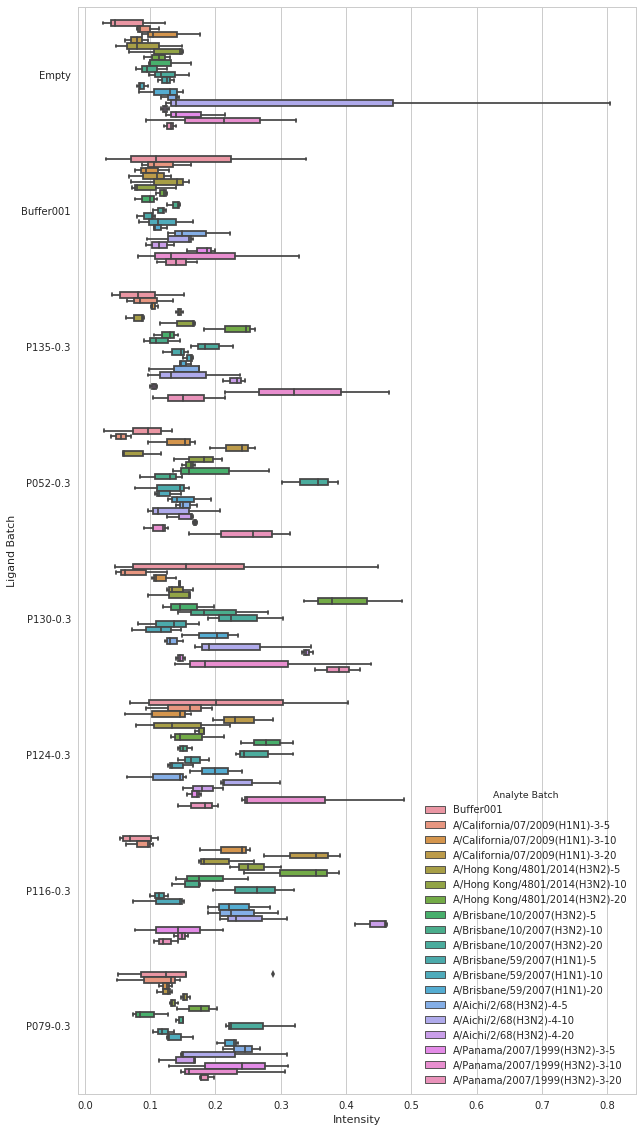

In [150]:
fig ,ax = plt.subplots(ncols=1,nrows=1,figsize=(10,20))
sns.boxplot(data=data_elisa.spots_pd, x="Intensity", y="Ligand Batch", hue="Analyte Batch", hue_order=['Buffer001',
        'A/California/07/2009(H1N1)-3-5','A/California/07/2009(H1N1)-3-10','A/California/07/2009(H1N1)-3-20',
        'A/Hong Kong/4801/2014(H3N2)-5','A/Hong Kong/4801/2014(H3N2)-10','A/Hong Kong/4801/2014(H3N2)-20',
        'A/Brisbane/10/2007(H3N2)-5','A/Brisbane/10/2007(H3N2)-10', 'A/Brisbane/10/2007(H3N2)-20',
        'A/Brisbane/59/2007(H1N1)-5','A/Brisbane/59/2007(H1N1)-10','A/Brisbane/59/2007(H1N1)-20',
        'A/Aichi/2/68(H3N2)-4-5', 'A/Aichi/2/68(H3N2)-4-10', 'A/Aichi/2/68(H3N2)-4-20',
       'A/Panama/2007/1999(H3N2)-3-5','A/Panama/2007/1999(H3N2)-3-10', 'A/Panama/2007/1999(H3N2)-3-20'],ax=ax)

In [115]:
frames = {}
for n,d in data_elisa.mean_on_analyte_batch().groupby(["Analyte Batch"]):
    rsd_back_2 = (d[d["Ligand Batch"] == "Buffer001"]["Intensity_rsd"].values[0])**2
    rsd_int_2 = d["Intensity_rsd"].apply(lambda x: x**2)
    d["Normed Error Div"] = (rsd_int_2 + rsd_back_2).apply(lambda x: np.sqrt(x))
    frames[n] = d
da_elisa_mean = pd.concat(frames)
    
    

/home/janekg89/Envs/flutype_webapp3/lib/python3.5/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [116]:
da_elisa_mean

Ligand Batch                  Analyte Batch  \
A/Aichi/2/68(H3N2)-4-10       0      Buffer001        A/Aichi/2/68(H3N2)-4-10   
                              19         Empty        A/Aichi/2/68(H3N2)-4-10   
                              38      P052-0.3        A/Aichi/2/68(H3N2)-4-10   
                              57      P079-0.3        A/Aichi/2/68(H3N2)-4-10   
                              76      P116-0.3        A/Aichi/2/68(H3N2)-4-10   
                              95      P124-0.3        A/Aichi/2/68(H3N2)-4-10   
                              114     P130-0.3        A/Aichi/2/68(H3N2)-4-10   
                              133     P135-0.3        A/Aichi/2/68(H3N2)-4-10   
A/Aichi/2/68(H3N2)-4-20       1      Buffer001        A/Aichi/2/68(H3N2)-4-20   
                              20         Empty        A/Aichi/2/68(H3N2)-4-20   
                              39      P052-0.3        A/Aichi/2/68(H3N2)-4-20   
                              58      P079-0.3        A/Aichi/2/68(H3N2)-4-20   
                              77      P116-0.3        A/Aichi/2/68(H3N2)-4-20   
                              96      P124-0.3        A/Aichi/2/68(H3N2)-4-20   
                              115     P130-0.3        A/Aichi/2/68(H3N2)-4-20   
                              134     P135-0.3        A/Aichi/2/68(H3N2)-4-20   
A/Aichi/2/68(H3N2)-4-5        2      Buffer001         A/Aichi/2/68(H3N2)-4-5   
                              21         Empty         A/Aichi/2/68(H3N2)-4-5   
                              40      P052-0.3         A/Aichi/2/68(H3N2)-4-5   
                              59      P079-0.3         A/Aichi/2/68(H3N2)-4-5   
                              78      P116-0.3         A/Aichi/2/68(H3N2)-4-5   
                              97      P124-0.3         A/Aichi/2/68(H3N2)-4-5   
                              116     P130-0.3         A/Aichi/2/68(H3N2)-4-5   
                              135     P135-0.3         A/Aichi/2/68(H3N2)-4-5   
A/Brisbane/10/2007(H3N2)-10   3      Buffer001    A/Brisbane/10/2007(H3N2)-10   
                              22         Empty    A/Brisbane/10/2007(H3N2)-10   
                              41      P052-0.3    A/Brisbane/10/2007(H3N2)-10   
                              60      P079-0.3    A/Brisbane/10/2007(H3N2)-10   
                              79      P116-0.3    A/Brisbane/10/2007(H3N2)-10   
                              98      P124-0.3    A/Brisbane/10/2007(H3N2)-10   
...                                        ...                            ...   
A/Panama/2007/1999(H3N2)-3-10 53      P052-0.3  A/Panama/2007/1999(H3N2)-3-10   
                              72      P079-0.3  A/Panama/2007/1999(H3N2)-3-10   
                              91      P116-0.3  A/Panama/2007/1999(H3N2)-3-10   
                              110     P124-0.3  A/Panama/2007/1999(H3N2)-3-10   
                              129     P130-0.3  A/Panama/2007/1999(H3N2)-3-10   
                              148     P135-0.3  A/Panama/2007/1999(H3N2)-3-10   
A/Panama/2007/1999(H3N2)-3-20 16     Buffer001  A/Panama/2007/1999(H3N2)-3-20   
                              35         Empty  A/Panama/2007/1999(H3N2)-3-20   
                              54      P052-0.3  A/Panama/2007/1999(H3N2)-3-20   
                              73      P079-0.3  A/Panama/2007/1999(H3N2)-3-20   
                              92      P116-0.3  A/Panama/2007/1999(H3N2)-3-20   
                              111     P124-0.3  A/Panama/2007/1999(H3N2)-3-20   
                              130     P130-0.3  A/Panama/2007/1999(H3N2)-3-20   
                              149     P135-0.3  A/Panama/2007/1999(H3N2)-3-20   
A/Panama/2007/1999(H3N2)-3-5  17     Buffer001   A/Panama/2007/1999(H3N2)-3-5   
                              36         Empty   A/Panama/2007/1999(H3N2)-3-5   
                              55      P052-0.3   A/Panama/2007/1999(H3N2)-3-5   
                              74      P079-0.3   A/Panama/2007/19

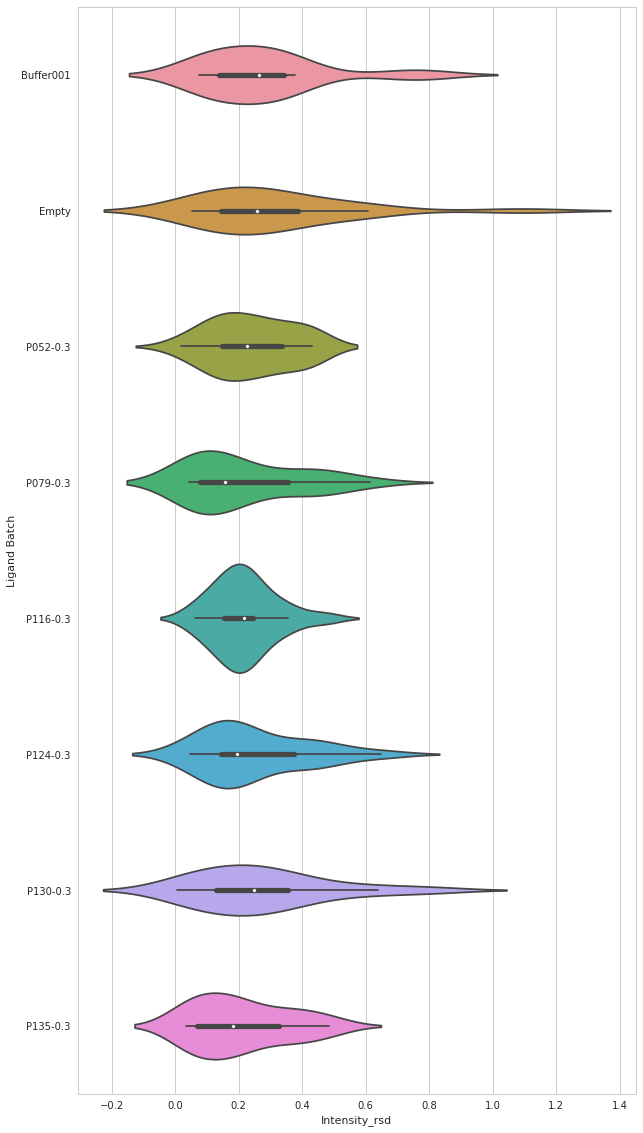

In [99]:
fig ,ax = plt.subplots(ncols=1,nrows=1,figsize=(10,20))
sns.violinplot(data=data_elisa.mean_on_analyte_batch(), x="Intensity_rsd", y="Ligand Batch", ax=ax)
#sns.violinplot(data=data_elisa.mean_on_analyte_batch(), x="Intensity_rsd", y="Analyte Batch", ax=ax)

In [100]:
np.sqrt(0.2**2+0.2**2)


0.28284271247461906

Selected Peptide have rather low relevance. This is bad.

## Normalization by Ligand Buffer


In [117]:
frames = {}
for cn, d in  data_elisa.spots_pd.groupby(["Collection","Ligand Batch"]):
    d["Intensity"] = d["Intensity"]/d[d["Analyte Batch"] == "Buffer001"]["Intensity"].median()
    frames[cn]=d
spots_pd_norm = pd.concat(frames)
data_elisa = a2.Data(spots_pd=spots_pd_norm)

/home/janekg89/Envs/flutype_webapp3/lib/python3.5/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



## Normalization by Analyte Buffer


In [118]:
frames = {}
for cn, d in  data_elisa.spots_pd.groupby(["Collection","Analyte Batch"]):
    d["Intensity"] = d["Intensity"]/d[d["Ligand Batch"] == "Buffer001"]["Intensity"].median()
    frames[cn]=d
spots_pd_norm = pd.concat(frames)
data_elisa = a2.Data(spots_pd=spots_pd_norm)

/home/janekg89/Envs/flutype_webapp3/lib/python3.5/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



## Check concentration dependence in elisa data set

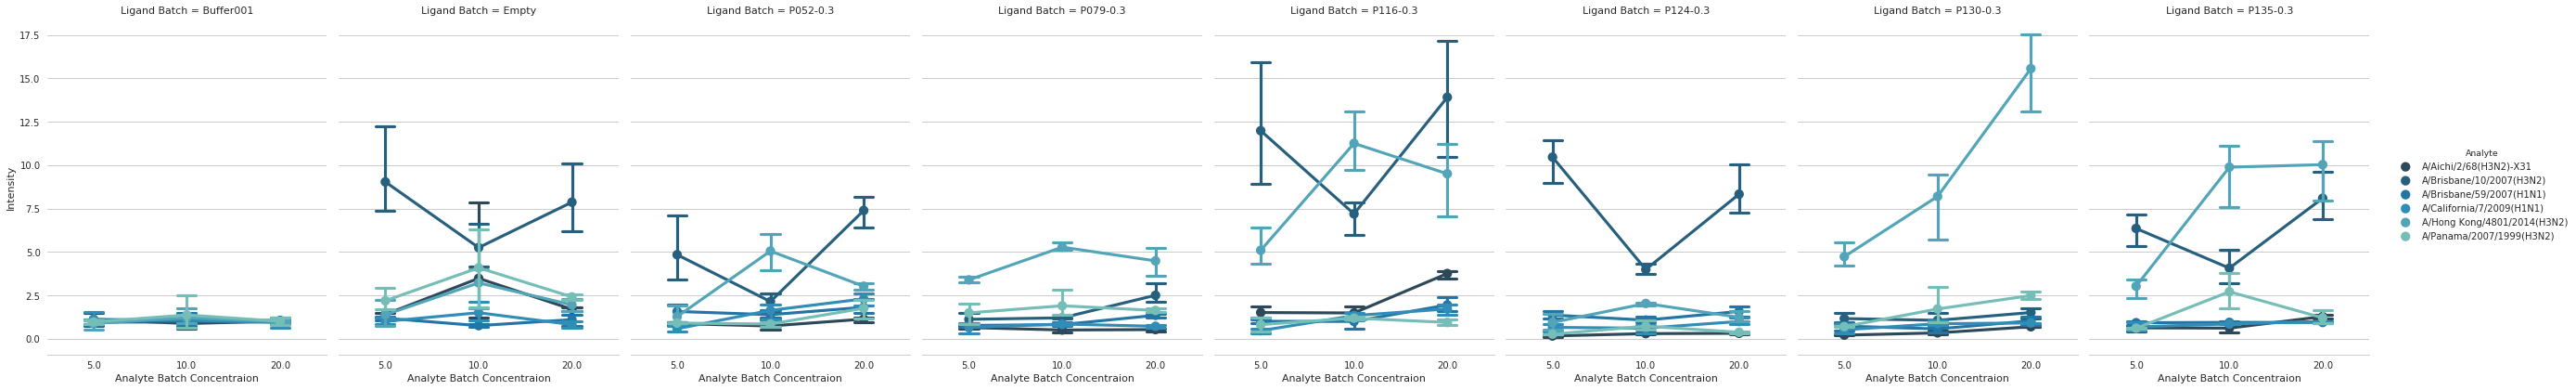

In [139]:
sns.set(style="whitegrid")
g = sns.factorplot(x="Analyte Batch Concentraion", y="Intensity", hue="Analyte", col="Ligand Batch", data=data_elisa.spots_pd,
                   capsize=.2, palette="YlGnBu_d", size=6, aspect=.75)
g.despine(left=True)

 - Concentration of Analyte Batch has no dependece on the Intensity for Ligand Batch == Buffer. This is good
 - qualitativ: correct relation between Concentration and Intensity


Question 1: How to normalize? 

 ## Correlation Plots

In [120]:
cmap = matplotlib.cm.get_cmap('Accent')

In [121]:
colors =  cmap(np.linspace(0,1,num=6))
color_list = []
for color in colors:
    for i in range(3):
        color_list.append(color)
color_list += [np.array([0 ,0 , 0, 0]) ]

Correlation of Peptides (check if viruses cluster in any corplot)
-  x -> Buffer 
- d -> 5 Concentration
- o -> 10 Concentration
- s -> 20 Concentration

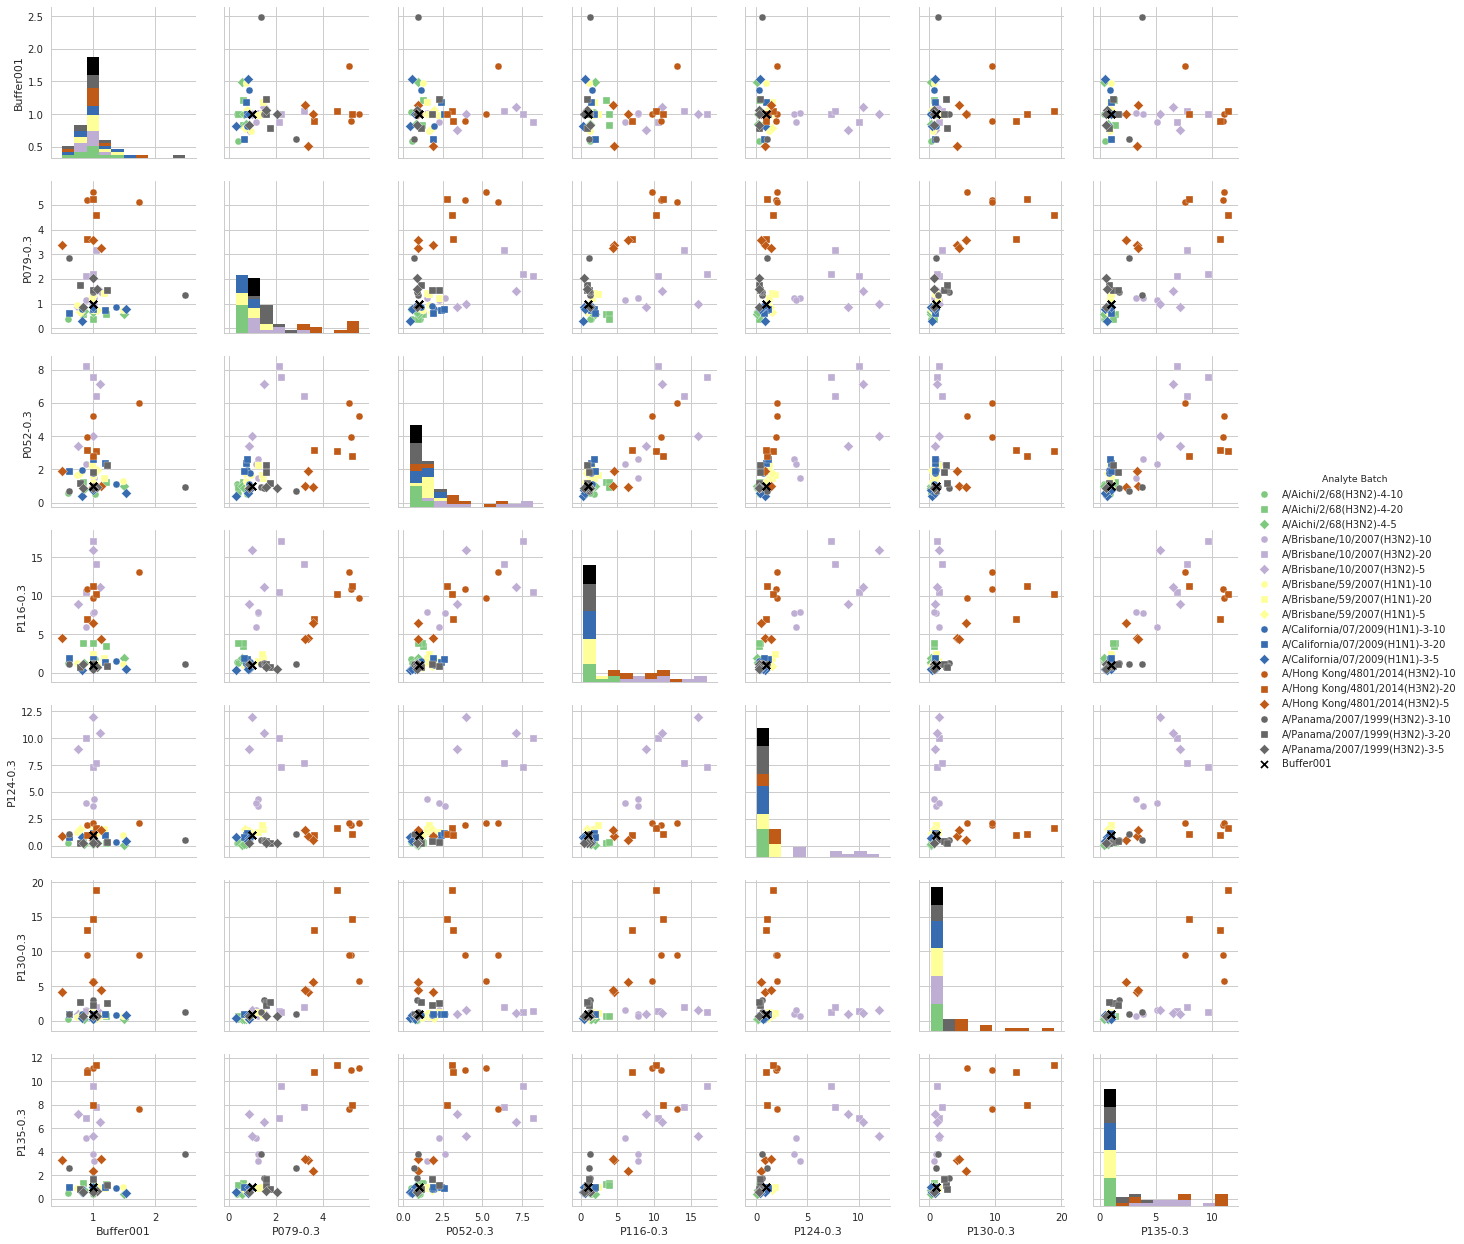

In [122]:
sns.pairplot(data=data_elisa.x.reset_index(),vars=["Buffer001","P079-0.3","P052-0.3","P116-0.3","P124-0.3","P130-0.3","P135-0.3"],hue="Analyte Batch",palette=color_list,markers= 6*["o","s","D"]+["x"])

In [123]:
d_analayte_x = data_elisa.spots_pd.pivot_table(values="Intensity",columns=["Ligand Batch","Analyte Batch Concentraion", "Replica"], index=["Analyte"])
d_new = d_analayte_x.transpose()

In [124]:

colors =  cmap(np.linspace(0,1,num=3))
color_list = []
for color in colors:
    #for i in range(3):
        color_list.append(color)
color_list += [np.array([0 ,0 , 0, 0]) ]

Correlation of Virsues 

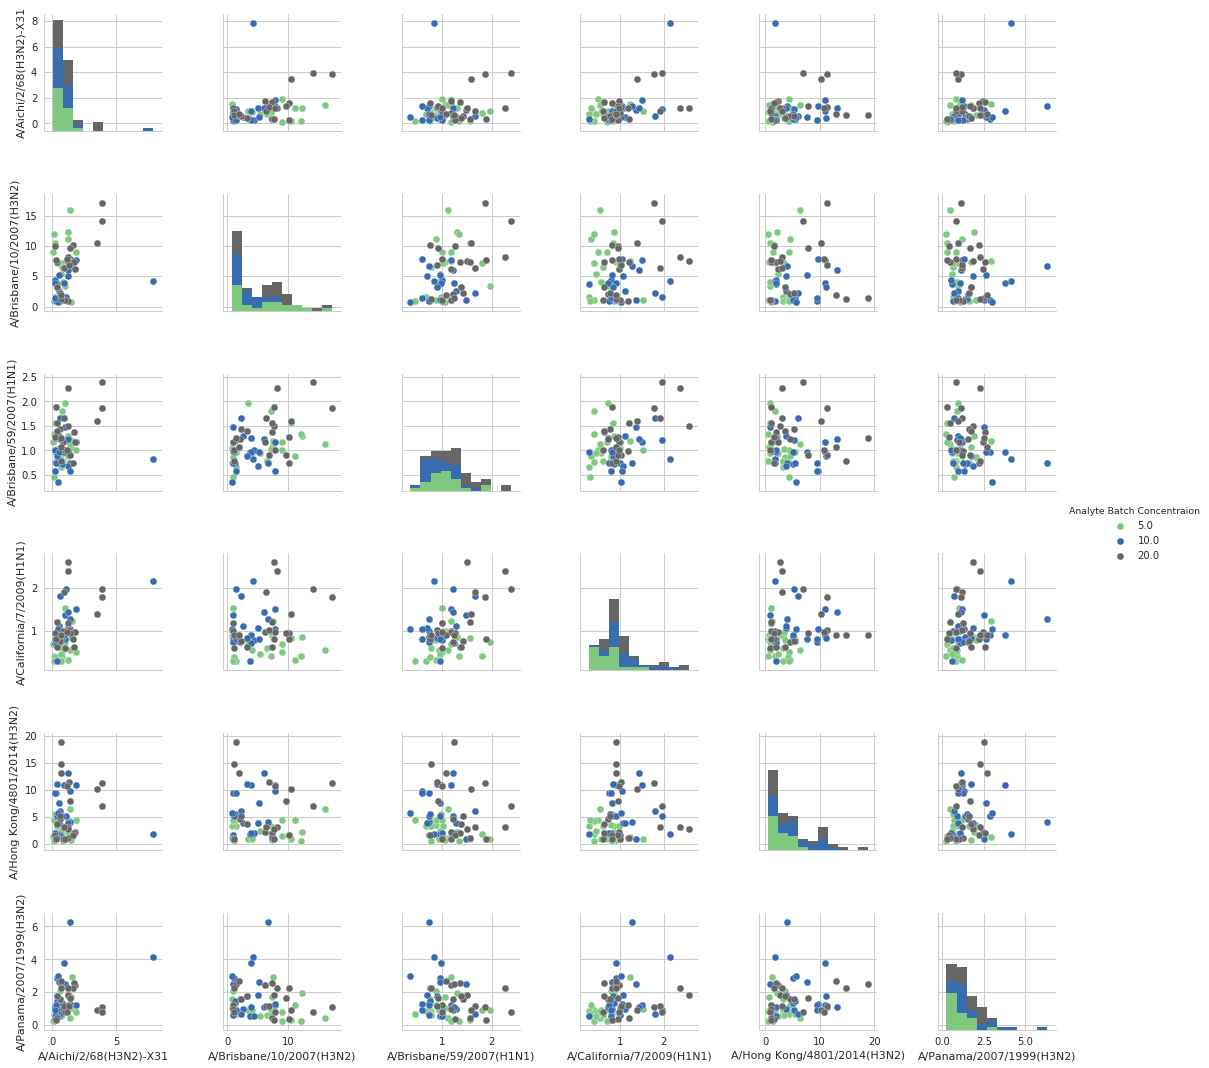

In [125]:
sns.pairplot(data=d_new.reset_index(),palette=color_list, hue="Analyte Batch Concentraion", vars=['A/Aichi/2/68(H3N2)-X31', 'A/Brisbane/10/2007(H3N2)', 'A/Brisbane/59/2007(H1N1)', 'A/California/7/2009(H1N1)', 'A/Hong Kong/4801/2014(H3N2)', 'A/Panama/2007/1999(H3N2)'])

## Heat/Cluster Map

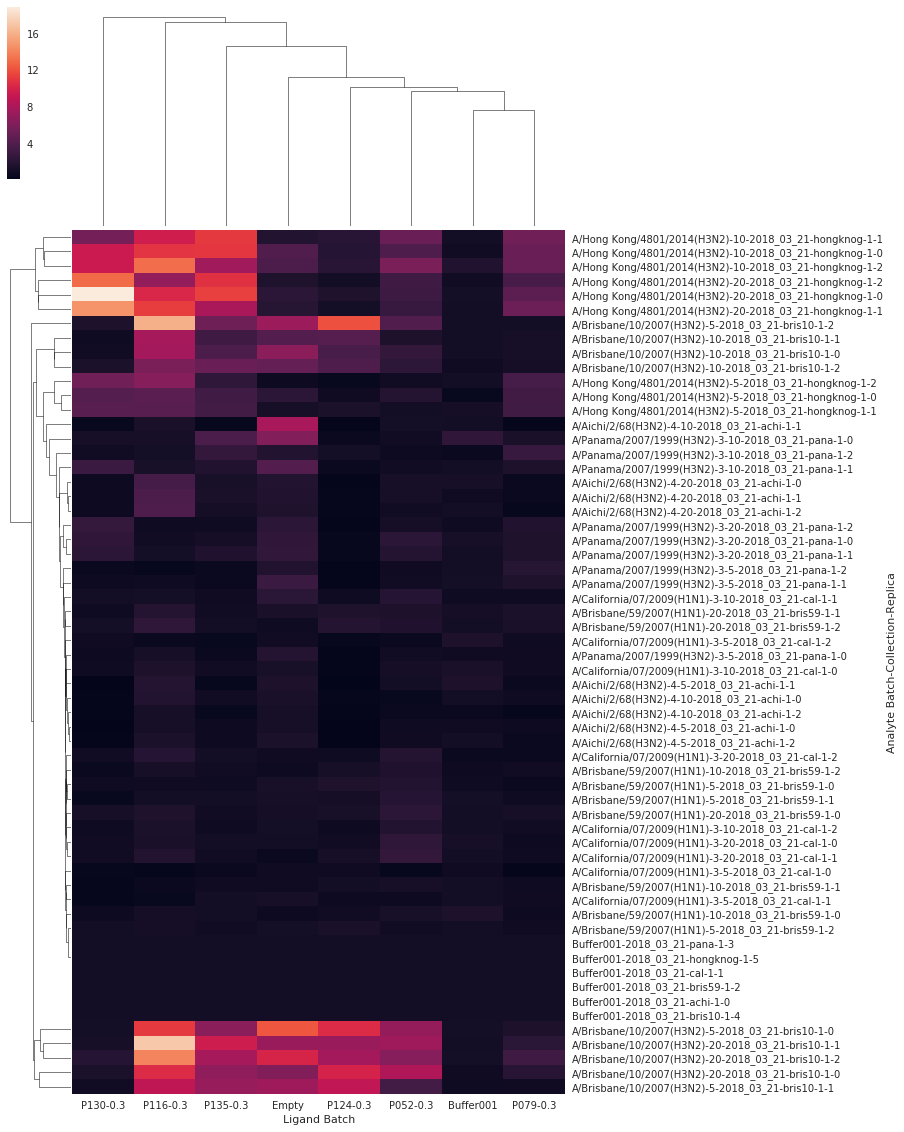

In [127]:
sns.clustermap(data_elisa.x,  method="single",figsize=(10,20))#metric="correlation",

## pca

In [128]:
#artificially increase data size
data_elisa_a = data_elisa.sample_on_collection(20)
# not used further

In [129]:
model_pca = data_elisa.x_pca_fit()
elisa_pca = model_pca.transform(data_elisa.x)

In [130]:
#sns.heatmap(model_pca.scalings_, center=True)

In [131]:
# creating colors for pca
le = preprocessing.LabelEncoder()
le.fit(data_elisa.y_names)
cs = le.transform(data_elisa.y_names)
colors =cs.astype(float) / cs.max()

In [132]:
trace1 = go.Scatter3d(
    x=elisa_pca[:,0],
    y=elisa_pca[:,1],
    z=elisa_pca[:,2],
    text = data_elisa.y_names+"<br>"+data_elisa.x.index.get_level_values("Collection"),
    mode='markers',
    hoverinfo='text',
    #hoverlabel=dict(bgcolor=list(colors)),
    marker=dict(
        size=7,
        color=colors,                # set color to an array/list of desired values
        colorscale='Jet',   # choose a colorscale
        opacity=0.99)
)

this = [trace1]
layout = go.Layout(
    #scene=dict(
    #    xaxis = dict(showspikes=False),
    #    yaxis = dict(showspikes=False),
    #    zaxis = dict(showspikes=False),

        

     #   )
    )
fig = go.Figure(data=this, layout=layout)
iplot(fig, filename='3d-scatter-colorscale')

In [133]:
complete = pd.DataFrame(columns=["Test", "Train"])
com = data_elisa.collections.unique().values
for i in range(1):
    complete.set_value(i,"Test",com)
    complete.set_value(i,"Train",com)



/home/janekg89/Envs/flutype_webapp3/lib/python3.5/site-packages/ipykernel_launcher.py:4: FutureWarning:

set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead

/home/janekg89/Envs/flutype_webapp3/lib/python3.5/site-packages/ipykernel_launcher.py:5: FutureWarning:

set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead



In [134]:
#no cross-validation on different microwells possible possible without 
ana = a2.Analysis(data_elisa, train_test=complete)
ana.calculate_all()

*****Nearest Neighbors*****
*****Fit Models*****
*****Predict*****
*****Decision Tree*****
*****Fit Models*****
*****Predict*****
*****LogisticRegression*****
*****Fit Models*****
*****Predict*****


In [135]:
frame = ana.complete_information()
len_frame =int(len(frame)/3)
frame_NN = frame[:len_frame]
frame_DT = frame[len_frame:2*len_frame]
frame_LR = frame[2*len_frame:3*len_frame]
print(frame_NN["TrueFalse"].mean())

0.75


## Nearest Neighbors

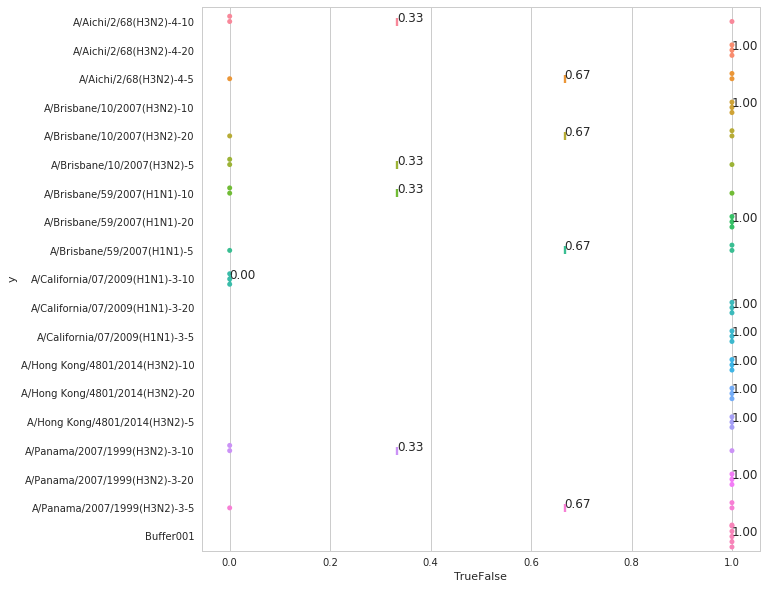

In [136]:
fig, ax = plt.subplots(ncols=1,nrows=1, figsize=(10,10))
#ax = sns.boxplot(data=frame_NN,y="y",x="TrueFalse",notch=True)
ax = sns.pointplot(data=frame_NN,y="y",x="TrueFalse",ci=None, join=False,hue="y", markers="|",)
for c in ax.collections:
    for of in c.get_offsets():
        ax.annotate("{:.2f}".format(of[0]), of)
        
ax = sns.swarmplot(data=frame_NN,y="y",x="TrueFalse")#, jitter=0.5)#, aspect=0.8)
ax.legend_.remove()

## Decision Tree

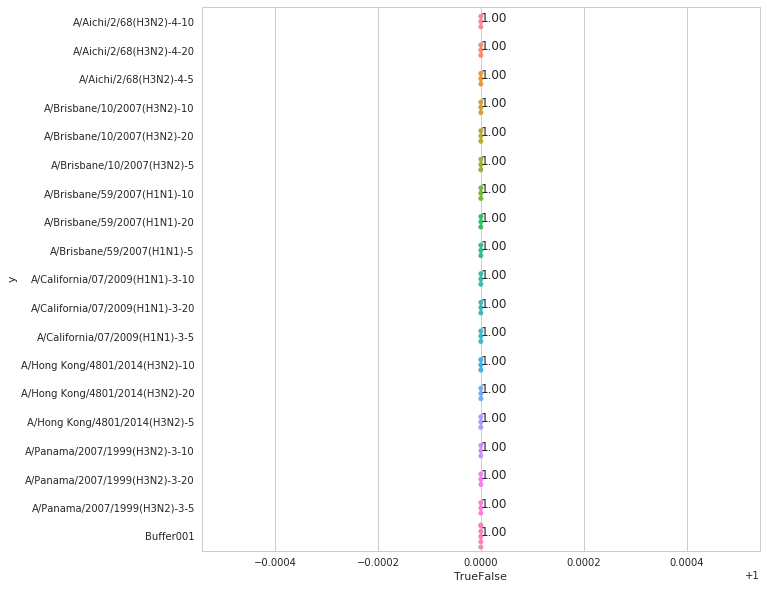

In [137]:
fig, ax = plt.subplots(ncols=1,nrows=1, figsize=(10,10))
#ax = sns.boxplot(data=frame_NN,y="y",x="TrueFalse",notch=True)
ax = sns.pointplot(data=frame_DT,y="y",x="TrueFalse",ci=None, join=False,hue="y", markers="|",)
for c in ax.collections:
    for of in c.get_offsets():
        ax.annotate("{:.2f}".format(of[0]), of)
        
ax = sns.swarmplot(data=frame_DT,y="y",x="TrueFalse")#, jitter=0.5)#, aspect=0.8)
ax.legend_.remove()

## Logistic Regression

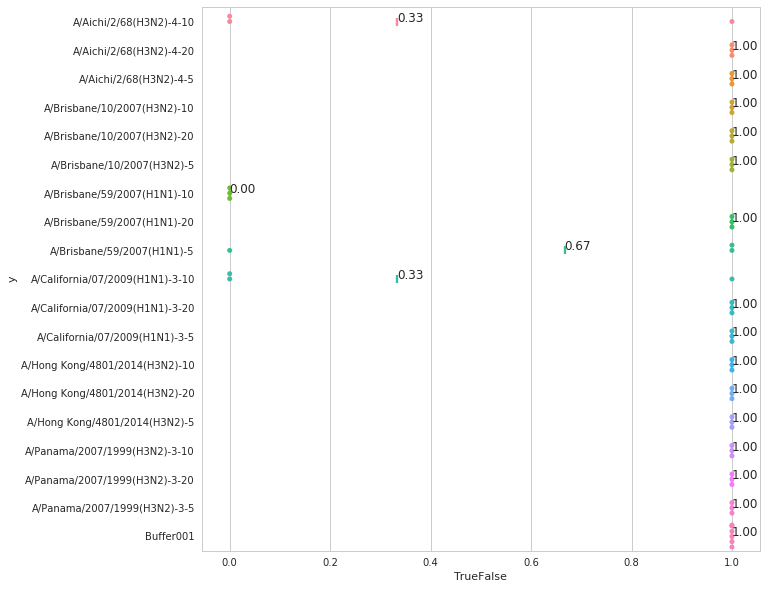

In [138]:
fig, ax = plt.subplots(ncols=1,nrows=1, figsize=(10,10))
#ax = sns.boxplot(data=frame_NN,y="y",x="TrueFalse",notch=True)
ax = sns.pointplot(data=frame_LR,y="y",x="TrueFalse",ci=None, join=False,hue="y", markers="|",)
for c in ax.collections:
    for of in c.get_offsets():
        ax.annotate("{:.2f}".format(of[0]), of)
        
ax = sns.swarmplot(data=frame_LR,y="y",x="TrueFalse")#, jitter=0.5)#, aspect=0.8)
ax.legend_.remove()
